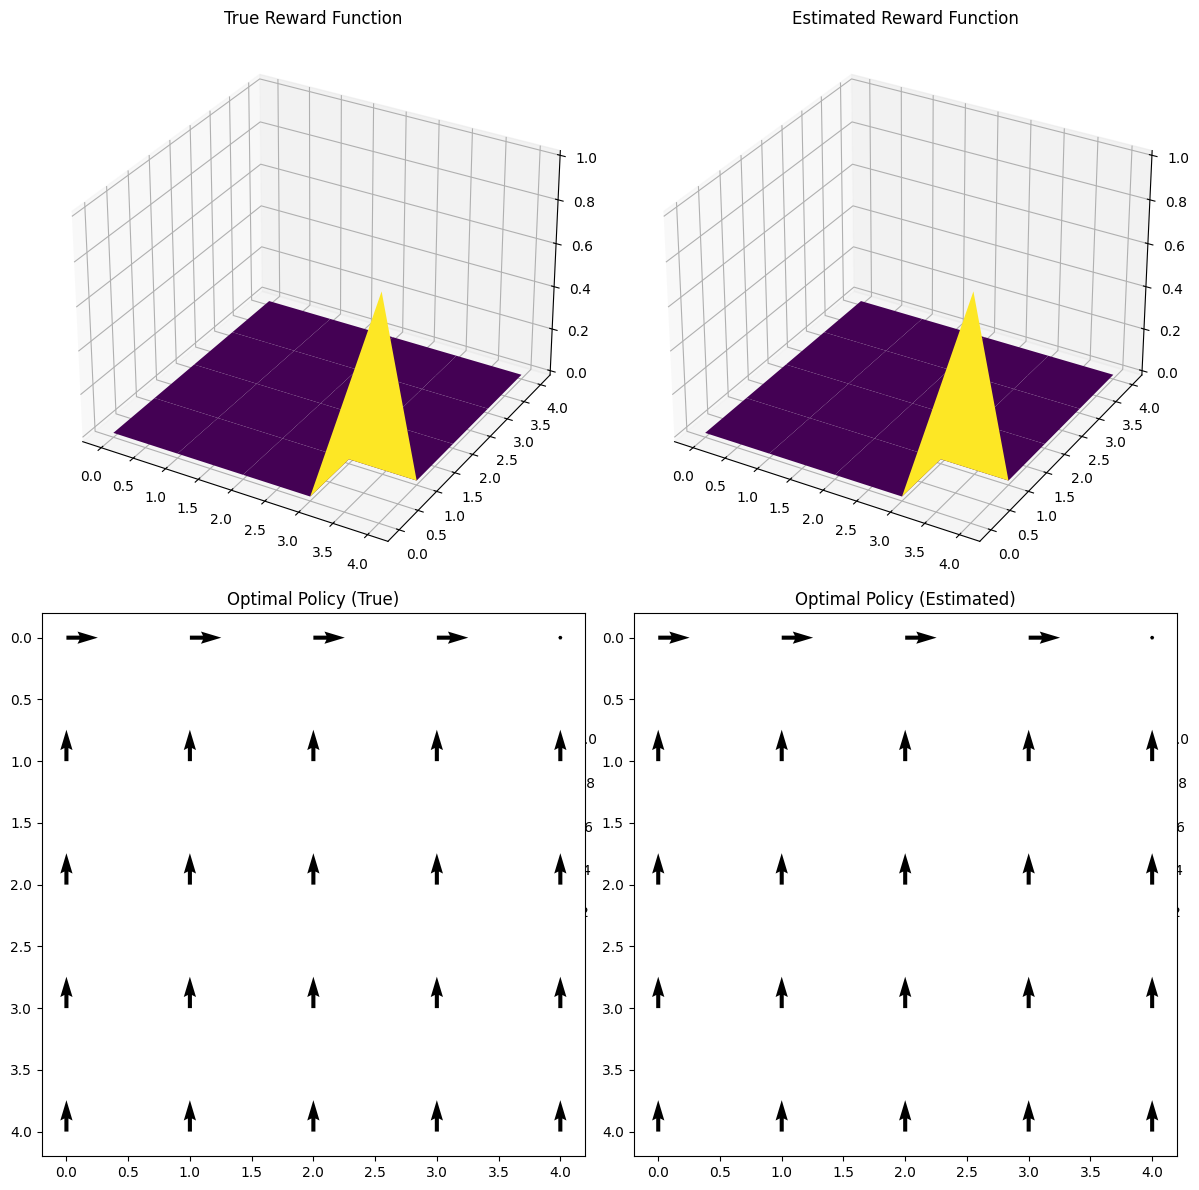

In [1]:
import numpy as np
from scipy.linalg import inv
from scipy.optimize import linprog
import matplotlib.pyplot as plt

def finite_lp_irl(num_states, num_actions, transition_probabilities, discount_factor, max_reward, optimal_policy, regularization=0.0):
    P_opt = np.vstack([transition_probabilities[s, :, optimal_policy[s]] for s in range(num_states)])
    inv_matrix = inv(np.eye(num_states) - discount_factor * P_opt)

    def drop_in_value(action, state):
        delta_p = P_opt[state, :] - transition_probabilities[state, :, action]
        return delta_p @ inv_matrix

    num_variables = num_states * 2
    c = np.concatenate([-np.ones(num_states), regularization * np.ones(num_states)])
    A_ub, b_ub = [], []

    for s in range(num_states):
        for a in range(num_actions):
            if a != optimal_policy[s]:
                row = np.zeros(num_variables)
                row[s] = 1
                row[num_states:] = -drop_in_value(a, s)
                A_ub.append(row)
                b_ub.append(0)

    for s in range(num_states):
        for a in range(num_actions):
            row = np.zeros(num_variables)
            row[num_states:] = -drop_in_value(a, s)
            A_ub.append(row)
            b_ub.append(0)

    for s in range(num_states):
        row = np.zeros(num_variables)
        row[num_states + s] = 1
        A_ub.append(row)
        b_ub.append(max_reward)

    bounds = [(0, None)] * num_variables
    res = linprog(c, A_ub=np.array(A_ub), b_ub=np.array(b_ub), bounds=bounds, method='highs')

    if not res.success:
        raise ValueError("Optimization failed: " + res.message)

    z_est, R_est = res.x[:num_states], np.clip(res.x[num_states:], None, max_reward)
    V_est = inv_matrix @ R_est
    return R_est, V_est

def value_iteration(num_states, num_actions, rewards, transition_probabilities, discount_factor, epsilon=1e-6, max_iterations=1000):
    V, policy = np.zeros(num_states), np.zeros(num_states, dtype=int)
    for _ in range(max_iterations):
        V_prev, Q = V.copy(), np.zeros((num_states, num_actions))
        for s in range(num_states):
            for a in range(num_actions):
                Q[s, a] = rewards[s] + discount_factor * transition_probabilities[s, :, a] @ V_prev
        V, policy = np.max(Q, axis=1), np.argmax(Q, axis=1)
        if np.max(np.abs(V - V_prev)) < epsilon:
            break
    return V, policy

grid_size, N, K, gamma, Rmax, lp_lambda = 5, 25, 5, 0.9, 1.0, 1
actions, P, noise_prob = ['up', 'down', 'left', 'right', 'stay'], np.zeros((N, N, K)), 0.3

for s in range(N):
    x, y = divmod(s, grid_size)
    for a_idx, action in enumerate(actions):
        next_x, next_y = x + (action == 'down') - (action == 'up'), y + (action == 'right') - (action == 'left')
        next_s = s if not (0 <= next_x < grid_size and 0 <= next_y < grid_size) else next_x * grid_size + next_y
        for noise_action in range(K):
            next_x_noise, next_y_noise = x + (noise_action == 1) - (noise_action == 0), y + (noise_action == 3) - (noise_action == 2)
            next_s_noise = s if not (0 <= next_x_noise < grid_size and 0 <= next_y_noise < grid_size) else next_x_noise * grid_size + next_y_noise
            P[s, next_s if noise_action == a_idx else next_s_noise, noise_action] = 1.0 - noise_prob if noise_action == a_idx else noise_prob / (K - 1)

true_R = np.zeros(N)
true_R[grid_size - 1] = 1.0

V_opt, opt_pi = value_iteration(N, K, true_R, P, gamma)
estimated_R, V_est = finite_lp_irl(N, K, P, gamma, Rmax, opt_pi, lp_lambda)
_, est_pi = value_iteration(N, K, estimated_R, P, gamma)

true_R_grid, estimated_R_grid = true_R.reshape(grid_size, grid_size), estimated_R.reshape(grid_size, grid_size)
action_to_vector = {0: (0, 1), 1: (0, -1), 2: (-1, 0), 3: (1, 0), 4: (0, 0)}
U_true, V_true, U_estimated, V_estimated = np.zeros((grid_size, grid_size)), np.zeros((grid_size, grid_size)), np.zeros((grid_size, grid_size)), np.zeros((grid_size, grid_size))

for s in range(N):
    x, y = divmod(s, grid_size)
    U_true[x, y], V_true[x, y] = action_to_vector[opt_pi[s]]
    U_estimated[x, y], V_estimated[x, y] = action_to_vector[est_pi[s]]

X, Y = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
fig, axs = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': '3d'})
axs[0, 0].plot_surface(X, Y, true_R_grid, cmap='viridis')
axs[0, 0].set_title('True Reward Function')
axs[0, 1].plot_surface(X, Y, estimated_R_grid, cmap='viridis')
axs[0, 1].set_title('Estimated Reward Function')

ax3 = fig.add_subplot(2, 2, 3)
ax3.quiver(X, Y, U_true, V_true)
ax3.set_title('Optimal Policy (True)')
ax3.set_aspect('equal')
ax3.invert_yaxis()

ax4 = fig.add_subplot(2, 2, 4)
ax4.quiver(X, Y, U_estimated, V_estimated)
ax4.set_title('Optimal Policy (Estimated)')
ax4.set_aspect('equal')
ax4.invert_yaxis()

plt.tight_layout()
plt.show()